In [1]:
#@title Install requirements
!pip install --upgrade pip
!pip install -r requirements.txt

  Using cached pip-24.1.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.1.2-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\Win10\Desktop\_code\toc-modeling\venv\Scripts\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#@title Imports packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap


# metrics
from sklearn.metrics import silhouette_samples, silhouette_score



In [3]:
#@title Utils

def get_columns_with_prefix(dataframe, prefix):
    # Get all column names from the DataFrame
    columns = dataframe.columns.tolist()

    # Filter columns with the specified prefix
    filtered_columns = [column for column in columns if column.startswith(prefix)]

    return filtered_columns

def compute_reduced_dimension(df, cols, method='t-sne', random_state=42):

  df_red = df.copy()

  X = df_red[cols]

  _x = method + "_1"
  _y = method + "_2"

  from sklearn.preprocessing import StandardScaler

  # method
  if method == "t-sne":
    from sklearn.manifold import TSNE
    red = TSNE(n_components=2,
               perplexity=30,
               n_iter=100000,
               learning_rate=0.1,
               early_exaggeration=2,
               n_iter_without_progress=200,
               metric='minkowski',
               random_state=random_state)

  if method == "umap":
    import umap
    red = red = umap.UMAP(random_state=random_state, n_jobs = 1)

  if method == "pca":
    from sklearn.decomposition import PCA
    red = red = PCA(n_components=2)

  Xs = StandardScaler().fit_transform(X)

  results = red.fit_transform(Xs)
  df_red[_x]=pd.Series(results[:,0])
  df_red[_y]=pd.Series(results[:,1])

  return df_red

def plot_2d(ax, df, _x, _y, _s, group_by, label, show_labels = 'false'):

  # select rows
  df_plot = df.copy()

  ax.tick_params(labelrotation=90)

  import matplotlib.cm as cm
  import itertools

  # Define the categories
  categories = df_plot[group_by].unique()
  palette = sns.color_palette("Set1")
  palette_iter = itertools.cycle(palette)
  category_colors = {category: next(palette_iter) for category in categories}

  sns.scatterplot(data=df_plot,
                  x=_x,
                  y=_y,
                  marker="." ,
                  size=1,
                  hue=group_by,
                  ax=ax,
                  palette= category_colors,
                  alpha = 0.5,
                  legend = False)

  sns.scatterplot(data=df_plot,
                  x=_x,
                  y=_y,
                  marker="o" ,
                  hue=group_by,
                  sizes=(25, 150),
                  size=_s,
                  ax=ax,
                  palette= category_colors,
                  alpha = 1,
                  legend = True)

  # handle categories with very low variance
  variances = df_plot.groupby(group_by)[_x].var()
  non_zero_var_categories = variances[variances > 0.001].index
  df_filtered = df_plot[df_plot[group_by].isin(non_zero_var_categories)]

  sns.kdeplot(data=df_filtered,
              x=_x,
              y=_y,
              hue=group_by,
              alpha=0.2,
              fill=False,
              warn_singular=False,
              palette= category_colors,
              legend = False,
              ax=ax)

  from adjustText import adjust_text as at
  if show_labels == "true":
    texts = []
    colors= df_plot[group_by].map(category_colors)
    labels = df_plot[label].astype(str)
    for i, txt in enumerate(labels):
        texts.append(ax.text(df_plot.at[i,_x], df_plot.at[i,_y], txt, ha='center',alpha=1, fontsize=7, c=colors[i]))

    # Adjust text positions to avoid overlap
    at(texts, ax=ax)

In [4]:
#@title Datos

df = pd.read_csv("https://raw.githubusercontent.com/fares-ipgp/toc-paper-2024/main/tocm.csv")
df

,sample,section,y__toc,geo__facies_num,geo__bioturb,geo__amb,xrd__qz,xrd__pl,xrd__fk,xrd__ca,xrd__py,xrd__clay,xrd__clay_i,xrd__clay_is,xrd__clay_cl,xrd__clay_k
0,PEVP1-15,PA,NaN,12,0,2,6.0,3.0,1.0,1.0,1.0,3.0,32.0,19.0,49.0,0.0
1,PEVP1-14,PA,0.09,12,0,2,6.0,3.0,1.0,3.0,1.0,3.0,35.0,16.0,49.0,0.0
2,PEVP1-13,PA,NaN,12,0,2,6.0,3.0,1.0,2.0,1.0,3.0,39.0,11.0,49.0,0.0
3,PEVP1-11,PA,NaN,12,0,2,6.0,3.0,1.0,3.0,1.0,3.0,30.0,15.0,55.0,0.0
4,PEVP1-10,PA,NaN,12,0,2,6.0,3.0,1.0,3.0,0.0,3.0,28.0,21.0,51.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,IG 5,IG,NaN,10,0,1,6.0,1.0,1.0,1.0,0.0,3.0,46.0,33.0,21.0,0.0
102,IG 4,IG,0.07,10,0,1,6.0,1.0,1.0,1.0,1.0,3.0,60.0,19.0,21.0,0.0
103,IG 3,IG,NaN,12,0,1,2.0,1.0,1.0,6.0,1.0,2.0,37.0,29.0,29.0,4.0
104,IG 2,IG,NaN,12,0,1,2.0,2.0,1.0,6.0,1.0,2.0,77.0,18.0,3.0,2.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample           106 non-null    object 
 1   section          106 non-null    object 
 2   y__toc           29 non-null     float64
 3   geo__facies_num  106 non-null    int64  
 4   geo__bioturb     106 non-null    int64  
 5   geo__amb         106 non-null    int64  
 6   xrd__qz          103 non-null    float64
 7   xrd__pl          103 non-null    float64
 8   xrd__fk          103 non-null    float64
 9   xrd__ca          103 non-null    float64
 10  xrd__py          103 non-null    float64
 11  xrd__clay        103 non-null    float64
 12  xrd__clay_i      101 non-null    float64
 13  xrd__clay_is     101 non-null    float64
 14  xrd__clay_cl     101 non-null    float64
 15  xrd__clay_k      101 non-null    float64
dtypes: float64(11), int64(3), object(2)
memory usage: 13.4+ KB


In [6]:
#@title Features
#@markdown Numerical values. Impute NaN as mean.
# bioturb	amb1	amb2
feature_names = []

columns_geological = get_columns_with_prefix(df,'geo__')
columns_xrd = get_columns_with_prefix(df,'xrd__')
columns_label = ['sample']

# Numeric feature names
feature_names.extend(columns_xrd)

# Mean imputer
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df[columns_xrd] = imp.fit_transform(df[columns_xrd])
df



,sample,section,y__toc,geo__facies_num,geo__bioturb,geo__amb,xrd__qz,xrd__pl,xrd__fk,xrd__ca,xrd__py,xrd__clay,xrd__clay_i,xrd__clay_is,xrd__clay_cl,xrd__clay_k
0,PEVP1-15,PA,NaN,12,0,2,6.0,3.0,1.0,1.0,1.0,3.0,32.0,19.0,49.0,0.0
1,PEVP1-14,PA,0.09,12,0,2,6.0,3.0,1.0,3.0,1.0,3.0,35.0,16.0,49.0,0.0
2,PEVP1-13,PA,NaN,12,0,2,6.0,3.0,1.0,2.0,1.0,3.0,39.0,11.0,49.0,0.0
3,PEVP1-11,PA,NaN,12,0,2,6.0,3.0,1.0,3.0,1.0,3.0,30.0,15.0,55.0,0.0
4,PEVP1-10,PA,NaN,12,0,2,6.0,3.0,1.0,3.0,0.0,3.0,28.0,21.0,51.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,IG 5,IG,NaN,10,0,1,6.0,1.0,1.0,1.0,0.0,3.0,46.0,33.0,21.0,0.0
102,IG 4,IG,0.07,10,0,1,6.0,1.0,1.0,1.0,1.0,3.0,60.0,19.0,21.0,0.0
103,IG 3,IG,NaN,12,0,1,2.0,1.0,1.0,6.0,1.0,2.0,37.0,29.0,29.0,4.0
104,IG 2,IG,NaN,12,0,1,2.0,2.0,1.0,6.0,1.0,2.0,77.0,18.0,3.0,2.0


In [7]:
#@title Targets { run: "auto" }

# Threshol toc value
df.loc[df['y__toc'].notna(),'y__hi_toc'] = df.loc[df['y__toc'].notna(),'y__toc'] > 1
df[['sample','y__hi_toc']]

,sample,y__hi_toc
0,PEVP1-15,NaN
1,PEVP1-14,False
2,PEVP1-13,NaN
3,PEVP1-11,NaN
4,PEVP1-10,NaN
...,...,...
101,IG 5,NaN
102,IG 4,False
103,IG 3,NaN
104,IG 2,NaN


c:\Users\Win10\Desktop\_code\toc-modeling\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Win10\Desktop\_code\toc-modeling\venv\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


4 0.36318313231038735 ['xrd__clay_is', 'geo__facies_num', 'geo__bioturb', 'geo__amb']
4 0.3350554784658209 ['xrd__clay_is', 'geo__facies_num', 'geo__bioturb', 'xrd__clay_cl']


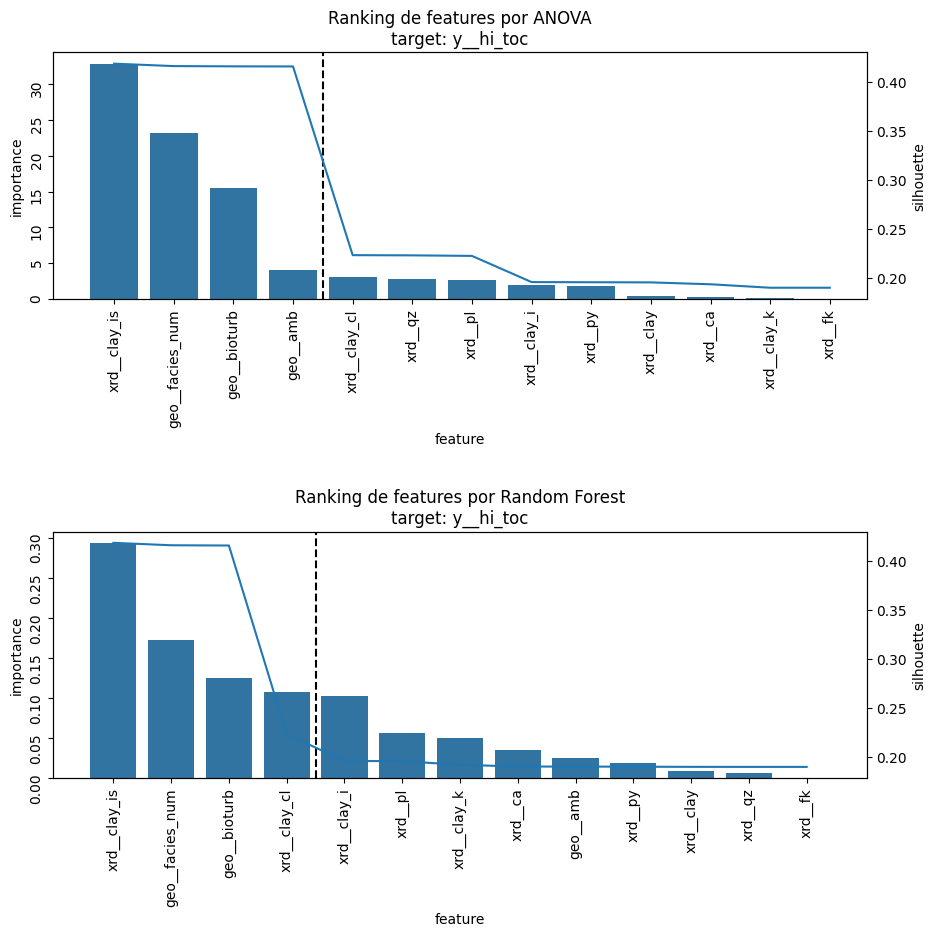

In [8]:
#@title Importancia de features { run: "auto" }

#@markdown En la gráfica de la se representan los features ordenados de mayor a menor importancia.
#@markdown Las barras representan en índice de importancia. Este índice (F score ANOVA y GINI impurity para Random Forest ).
#@markdown La línea azul representa el índice de silhouette promedio resultante de haber seleccionado los N features más significativos.

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import f_classif

#features = "all" #@param ["all","geological","analysis_xrd"]
target = "y__hi_toc" #@param ["y__hi_toc","y__hi_if","y__hi_toc&if"]
threshold = 0.075 #@param {type:"slider", min:0, max:1, step:0.025}
max_features = 4 #@param {type:"slider", min:1, max:15, step:1}

methods = ("ANOVA","Random Forest")

best_features = {}

# Setup figure
fig, axes = plt.subplots(len(methods),1)
fig.set_size_inches(10,10)

for tidx, method in enumerate(methods):

  # only use labeled data
  df_show = df.copy()
  df_show = df_show.loc[df_show[target].notna()]
  df_show = df_show.reset_index(drop=True)

  cols = columns_geological + columns_xrd

  # features
  from sklearn.preprocessing import StandardScaler
  ss= StandardScaler()
  ss.fit(df_show[cols])

  X_raw = df_show[cols]
  X_scaled=pd.DataFrame(ss.transform(X_raw),columns = X_raw.columns)

  # method
  cols = cols
  Xr= X_scaled

  # target
  y = df_show[target].astype(bool)

  if method == "Random Forest":
      model = RandomForestClassifier(n_estimators=10000, min_samples_split=4, min_samples_leaf=2, criterion='gini')
      model.fit(Xr, y)
      importance = model.feature_importances_
      df_importance = pd.DataFrame({'feature': cols, 'importance': importance})
  elif method == "ANOVA":
      importance, p_value = f_classif(Xr, y)
      df_importance = pd.DataFrame({'feature': cols, 'importance': importance})
  elif method == "LinearSVC":
      model = LinearSVC()
      model.fit(Xr, y)
      importance = np.abs(model.coef_[0])
      df_importance = pd.DataFrame({'feature': cols, 'importance': importance})
  else:
      importance = []

  df_sorted = df_importance.sort_values('importance', ascending=False)

  scores=[]
  num_features=[]

  for idx, feature in enumerate(df_sorted['feature']):
    _best_features= list(df_sorted['feature'].head(idx+1))
    df_sil=df_show[ _best_features + [target]].copy()
    df_sil['silhouette']=silhouette_samples(df_sil[_best_features],df_sil[target])
    scores+=[df_sil.agg({'silhouette': ['mean']})['silhouette']]

  scores=list(np.array(scores).reshape(-1))
  #max_features=scores[3:].index(max(scores[3:]))+4

  axes[tidx].tick_params(labelrotation=90)
  sns.barplot(df_sorted.head(50),x='feature',y='importance',ax=axes[tidx])

  ax2=axes[tidx].twinx()
  ax2.plot(df_sorted.head(50)['feature'],scores[:50])

  axes[tidx].axvline(x=max_features-0.5, color='black', linestyle='--')

  best_features[method]= list(df_sorted['feature'].head(max_features))
  print(max_features,silhouette_score(Xr[best_features[method]],y), best_features[method])

  ax2.set_ylabel('silhouette')
  axes[tidx].set_title('Ranking de features por ' + method + '\ntarget: ' + target)
  fig.tight_layout(pad=3.0)

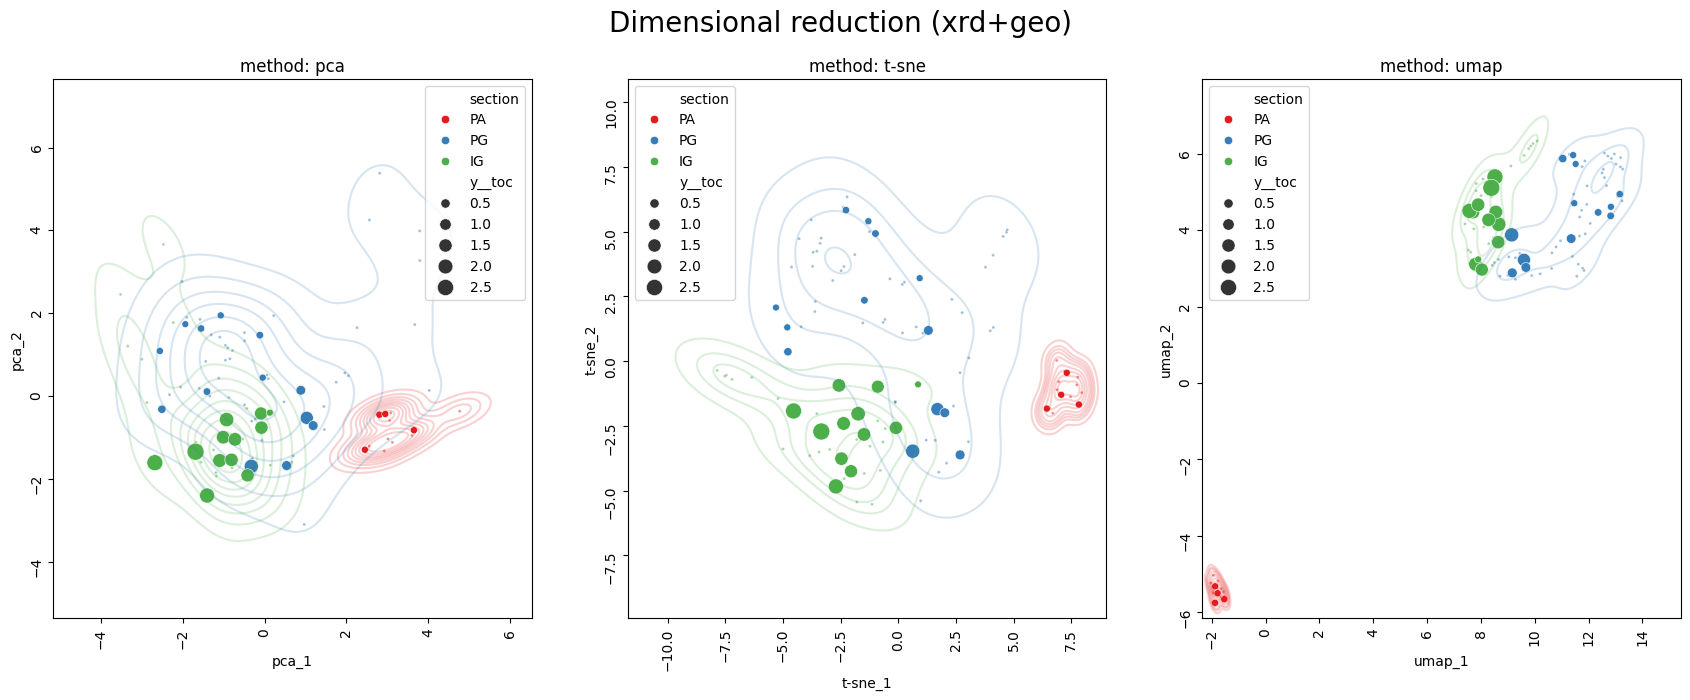

In [9]:
#@title Reducción dimensional - comparación de métodos { run: "auto" }

features = "xrd+geo" #@param ["xrd+geo","xrd","best_anova","best_rf"]
target = "y__toc" #@param ["y__toc","y__if","y__toc*if", "y__hi_toc", "y__hi_if", "y__hi_toc*if"]
methods=('pca','t-sne','umap')

feature_sets = {'xrd+geo': columns_geological + columns_xrd ,
                'best_anova': best_features['ANOVA']}

fig, axes = plt.subplots(1,len(methods))
fig.set_size_inches(21,7)
fig.suptitle('Dimensional reduction (' + features + ')', fontsize=20)

# select features
cols = feature_sets[features]

df=compute_reduced_dimension(df, cols, method='t-sne')
df=compute_reduced_dimension(df, cols, method='umap')
df=compute_reduced_dimension(df, cols, method='pca')

# Sweep over q values and plot resuts
for idx, method in enumerate(methods):
  axes[idx].set_title( 'method: ' + method)
  plot_2d(axes[idx], df, method + '_1'  , method + '_2' , target ,'section', 'y__toc', show_labels = 'false')

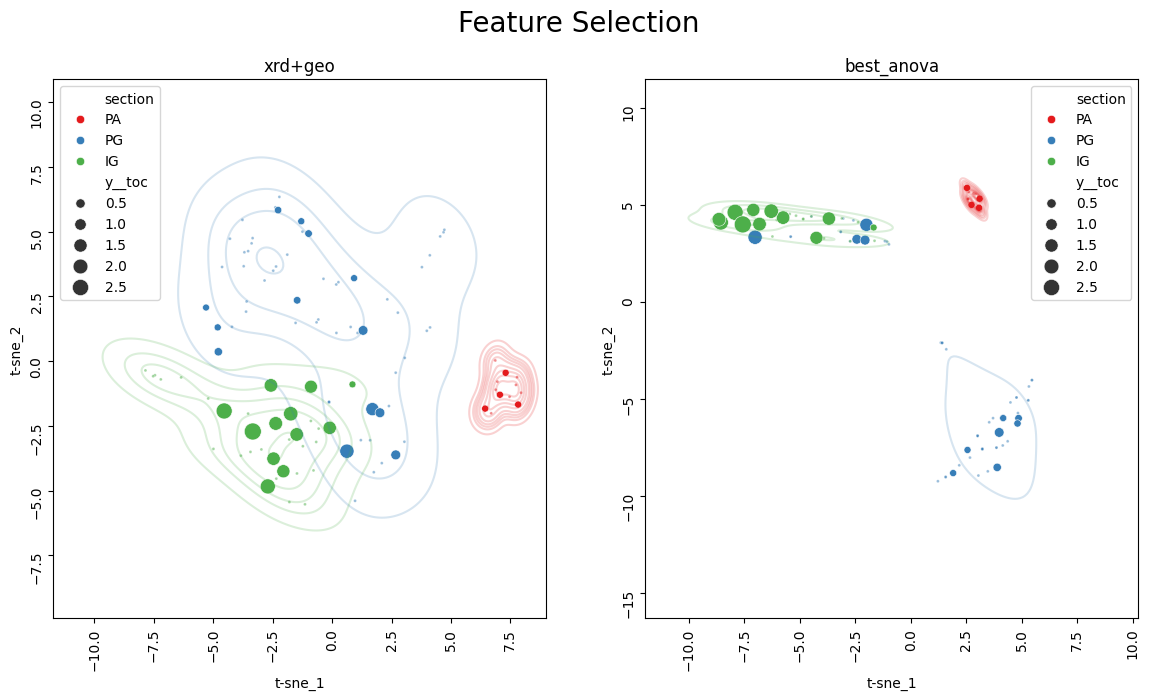

In [10]:
#@title Selección de features - comparacion { run: "auto" }

method = "t-sne" #@param ["pca","t-sne","umap"]
target = "y__toc" #@param ["y__toc","y__if","y__toc*if", "y__hi_toc", "y__hi_if", "y__hi_toc*if"]

feature_sets = {#'xrd':columns_xrd,
                'xrd+geo': columns_geological + columns_xrd ,
                'best_anova': best_features['ANOVA']
                #,'best_rf': best_features['Random Forest']
                }

fig, axes = plt.subplots(1,len(feature_sets))
fig.set_size_inches(14,7)
fig.suptitle('Feature Selection', fontsize=20)

for fidx, features in enumerate(feature_sets):

  # select features
  cols = feature_sets[features]
  df=compute_reduced_dimension(df, cols, method=method)

  # Sweep over q values and plot resuts
  axes[fidx].set_title(features)
  plot_2d(axes[fidx], df, method + '_1'  , method + '_2' , target ,'section', 'sample', show_labels = 'false')

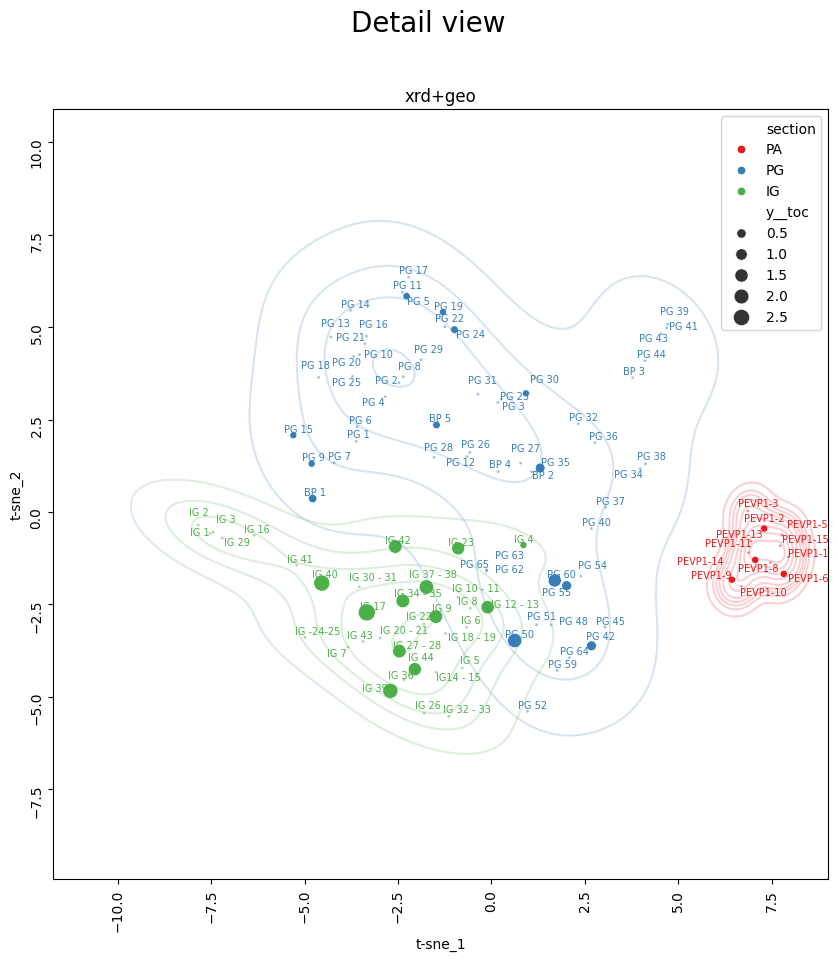

In [11]:
#@title Visualización en dimensión reducida - detalle { run: "auto" }

features = "xrd+geo" #@param ["xrd+geo","xrd","best_anova","best_rf"]

method = "t-sne" #@param ["pca","t-sne","umap"]
target = "y__toc" #@param ["y__toc","y__if","y__toc*if", "y__hi_toc", "y__hi_if", "y__hi_toc&if"]

feature_sets = {'xrd+geo': columns_geological + columns_xrd,
                'best_anova': best_features['ANOVA']}

fig, axes = plt.subplots()
fig.set_size_inches(10,10)
fig.suptitle('Detail view', fontsize=20)

# select features
cols = feature_sets[features]
df=compute_reduced_dimension(df, cols, method=method)

# Sweep over q values and plot resuts
axes.set_title(features)
plot_2d(axes, df, method + '_1'  , method + '_2' , target ,'section', 'sample', show_labels = 'true')

In [12]:
#@title Feature sets and target { run: "auto" }

train_features = "best_anova" #@param ["xrd+geo","xrd","best_anova","best_rf"]
target = "y__hi_toc" #@param ["y__hi_toc","y__hi_if","y__hi_toc&if"]

feature_sets = {'xrd+geo': columns_geological + columns_xrd ,
                'best_anova': best_features['ANOVA']}

# only use labeled data
df_train = df.copy()
df_train = df_show.loc[df_show[target].notna()]
df_train = df_show.reset_index(drop=True)

cols =   feature_sets[train_features]
X = df_train[cols]

# target
y = df_train[target].astype(int)

In [13]:
#@title Models { run: "auto" }

from sklearn.pipeline import Pipeline


# Scaling
from sklearn.preprocessing import StandardScaler

# Feature selection
from sklearn.feature_selection import f_classif

# Model
from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm

from skopt.space import Real, Categorical, Integer

pipelines={}
param_spaces={}
opts={}
cv_params={}

#
# logistic
#

pipelines['logistic'] = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler preprocessing step
    ('classifier', linear_model.LogisticRegression(solver='liblinear'))           # Classification model (SVM in this case)
])

param_spaces['logistic'] = {
    'classifier__C': Real(1e-4, 1e+3, prior='log-uniform'),
    'classifier__penalty': Categorical(['l2', 'l1'])
}

cv_params['logistic']={'n_iter':100,
                       'n_points':10}

#
# SVC
#

pipelines['svc'] = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler preprocessing step
    ('classifier', svm.SVC(probability=True))           # Classification model (SVM in this case)
])

param_spaces['svc'] = {
    'classifier__C': Real(1e-4 , 1e+3, prior='log-uniform'),
    'classifier__kernel': Categorical(['sigmoid'])
}

cv_params['svc']={'n_iter':100,
                       'n_points':10}

#
# KNN
#

pipelines['knn'] = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler preprocessing step
    ('classifier', neighbors.KNeighborsClassifier())           # Classification model
])

param_spaces['knn'] = {
    'classifier__n_neighbors': Integer(2,8),
    'classifier__weights': Categorical(['uniform', 'distance']),
    'classifier__p': Integer(1,4)
}

cv_params['knn']={'n_iter':100,
                  'n_points':10}


In [14]:
#@title Train models { run: "auto" }
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

best_results={}
results={}
models={}
loo = {}

def custom_callback(res):
    print(f"Epoch {len(res.func_vals)} - Best score: {res.fun:.6f}, Best params: {res.x}, last params:{res.x_iters[-1]}, last score:{res.func_vals[-1]} ")
    #print(res)

for pipeline in pipelines:

  print(f"Training {pipeline}")

  # Define Leave-One-Out cross-validation strategy
  loo[pipeline] = LeaveOneOut()

  opts[pipeline] = BayesSearchCV( pipelines[pipeline],
                                  param_spaces[pipeline],
                                  cv= loo[pipeline],  # LOO cross-validation
                                  return_train_score = True,
                                  refit=True,
                                  n_jobs=-1,  # Number of CPU cores to use (-1 means all available cores)
                                  verbose=0, **cv_params[pipeline]
                                 )
  opts[pipeline].fit(X, y,callback=custom_callback)
  models[pipeline]=opts[pipeline].best_estimator_
  results[pipeline]=pd.DataFrame.from_dict(opts[pipeline].cv_results_)

  print(f"Best hyperparameters for {pipeline}:", opts[pipeline].best_params_)
  print(f"Best cross-validation score for {pipeline}:", opts[pipeline].best_score_)


Training logistic
Epoch 10 - Best score: -0.965517, Best params: [0.0005188473624432547, 'l2'], last params:[0.2922451012733483, 'l2'], last score:-0.9655172413793104 
Epoch 20 - Best score: -0.965517, Best params: [0.0005188473624432547, 'l2'], last params:[0.0025820472098776743, 'l2'], last score:-0.9655172413793104 


c:\Users\Win10\Desktop\_code\toc-modeling\venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 'l2'] before, using random point [370.8348330986357, 'l1']
  warnings.warn(
c:\Users\Win10\Desktop\_code\toc-modeling\venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 'l2'] before, using random point [37.979929280414716, 'l2']
  warnings.warn(
c:\Users\Win10\Desktop\_code\toc-modeling\venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 'l2'] before, using random point [0.042616298779193346, 'l2']
  warnings.warn(
c:\Users\Win10\Desktop\_code\toc-modeling\venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.0001, 'l2'] before, using random point [308.36394973435574, 'l2']
  warnings.warn(
c:\Users\Win10\Desktop\_code\toc-modeli

Epoch 30 - Best score: -0.965517, Best params: [0.0005188473624432547, 'l2'], last params:[0.11855571870452956, 'l1'], last score:-0.7241379310344828 
Epoch 40 - Best score: -0.965517, Best params: [0.0005188473624432547, 'l2'], last params:[0.004037924575994831, 'l2'], last score:-0.9655172413793104 
Epoch 50 - Best score: -0.965517, Best params: [0.0005188473624432547, 'l2'], last params:[0.07929033471197318, 'l2'], last score:-0.9655172413793104 
Epoch 60 - Best score: -0.965517, Best params: [0.0005188473624432547, 'l2'], last params:[128.83402704990934, 'l2'], last score:-0.896551724137931 
Epoch 70 - Best score: -0.965517, Best params: [0.0005188473624432547, 'l2'], last params:[2.9316519551539524, 'l2'], last score:-0.896551724137931 


In [ ]:
#@title View results { run: "auto" }

features = "xrd+geo" #@param ["xrd+geo","xrd","best_anova","best_rf"]

method = "t-sne" #@param ["pca","t-sne","umap"]
target = "y__hi_toc" #@param ["y__hi_toc", "y__hi_if", "y__hi_toc&if"]
show_labels = 'false'

feature_sets = {'xrd+geo': columns_geological + columns_xrd ,
                'xrd':columns_xrd,
                'best_anova': best_features['ANOVA'],
                'best_rf': best_features['Random Forest']}

fig, axes = plt.subplots(1,len(pipelines))
fig.set_size_inches(20,6)
fig.suptitle('Model Prediction (' + train_features + ')', fontsize=15)

# select features
cols = feature_sets[features]
df_plot=compute_reduced_dimension(df, cols, method=method)

for idx, pipeline in enumerate(pipelines):

  # Get best columns

  # test scores
  best_results=results[pipeline][results[pipeline]['rank_test_score']==1]
  test_score_cols=['split'+ str(split) + '_test_score' for split in range( opts[pipeline].n_splits_)  ]
  df_plot.loc[ df_plot[target].notnull(),'test_score_'+pipeline]=np.array(best_results[test_score_cols].mean()).astype('float64')

  # train scores
  best_results=results[pipeline][results[pipeline]['rank_train_score']==1]
  train_score_cols=['split'+ str(split) + '_train_score' for split in range( opts[pipeline].n_splits_)  ]
  df_plot.loc[ df_plot[target].notnull(),'train_score_'+pipeline]=np.array(best_results[test_score_cols].mean()).astype('float64')

  # probability (TODO: average between all ???)
  features=opts[pipeline].feature_names_in_
  df_plot['prob_'+pipeline+'__'+target]=opts[pipeline].best_estimator_.predict_proba(df_plot[features]).astype('float64')[:,1]

  # prediction (TODO: average mayority between all ???)
  df_plot['pred_'+pipeline+'__'+target]=opts[pipeline].best_estimator_.predict(df_plot[features]).astype('int')

  # Sweep over q values and plot resuts
  axes[idx].set_title(pipeline)# + '\nDimension reduction method: ' + method )

  # Original samples
  # plot_2d(axes[idx], df_plot, method + '_1'  , method + '_2' , target ,'section', 'sample', show_labels = 'false')

  # Prediction

  # Define the categories
  import matplotlib.cm as cm
  import itertools

  categories = df_plot[target].unique()
  palette = sns.color_palette("Set1")
  palette_iter = itertools.cycle(palette)
  category_colors = {category: next(palette_iter) for category in categories}


  # pred contour
  sns.kdeplot(df_plot,  x= method+'_1'  , y=method+'_2', hue='pred_'+pipeline+'__'+target, legend=False, palette=category_colors, alpha=0.5, ax=axes[idx])

  # target
  sizes = {True: 100, False: 10,  None: 0}
  sns.scatterplot(df_plot,  x= method+'_1'  , y=method+'_2', hue=target ,size=target, palette=category_colors, legend=True ,marker='o', ax=axes[idx], sizes=sizes)

  # pred points
  pred_colors=df_plot['pred_'+pipeline+'__'+target].map(category_colors)
  try:
    sns.scatterplot(df_plot,
                    x= method+'_1',
                    y=method+'_2',
                    ec=pred_colors,
                    fc="none",
                    legend=True,
                    size='prob_'+pipeline+'__'+target, marker='o',
                    linewidth=1,
                    ax=axes[idx])
  except  Exception as e:
    print("An error occurred:", e)

  _x=method+'_1'
  _y=method+'_2'

  from adjustText import adjust_text as at
  if show_labels == "true":
    texts = []
    labels = df_plot['sample'].astype(str)
    for i, txt in enumerate(labels):
        texts.append(axes[idx].text(df_plot.at[i,_x], df_plot.at[i,_y], txt, ha='center',alpha=1, fontsize=7))

    # Adjust text positions to avoid overlap
    at(texts, ax=axes[idx])

In [ ]:
#@title Accuracy { run: "auto" }

fig, axes = plt.subplots(1,len(pipelines))
fig.set_size_inches(20,6)
fig.suptitle('Accuracy' + ' (' + train_features + ')', fontsize=15)

accuracies = {}

for idx, pipeline in enumerate(pipelines):

  data=results[pipeline]

  data['model_number'] = data.reset_index().index + 1

  df_list=[]

  source_df = pd.DataFrame(data)

  for ds in ('train','test'):

    melted_df = pd.melt(source_df, id_vars=['model_number','rank_test_score','params'],
                        value_vars=[col for col in source_df.columns if 'split' in col and ds+'_score' in col],
                        var_name='split_score', value_name= 'score')

    melted_df['split'] = melted_df['split_score'].str.extract(r'split(\d+)').astype(int)
    melted_df['train_test'] = melted_df['split_score'].str.extract(r'split\d+_(\w+)_score')

    melted_df.drop(columns=['split_score'], inplace=True)

    df_list.append(melted_df)

  #df_pivot=pd.concat(df_list, ignore_index=True)
  df_pivot=pd.concat(df_list, ignore_index=True)

  accuracies[pipeline] = df_pivot

  sns.pointplot(df_pivot,
                x='rank_test_score',
                y='score',
                hue='train_test',
                errorbar=('ci', 95),
                ax=axes[idx])
  axes[idx].set_ylim([0.3, 1.02])
  axes[idx].set_title(pipeline)


In [ ]:

# Create a list of DataFrames with a new column 'key' representing the dictionary key
dfs_with_key = []

for key, df_accuracy in accuracies.items():
    df_accuracy['model'] = key
    dfs_with_key.append(df_accuracy)
    
df_accuracies = pd.concat(dfs_with_key, ignore_index=True)

df_best_accuracies = df_accuracies[df_accuracies['rank_test_score']==1]

df_average_scores = df_best_accuracies.groupby(['model','train_test'])['score'].agg(['mean', 'std', 'count']).reset_index()

# Calculate the 95% confidence interval
df_average_scores['ci95'] = 1.96 * (df_average_scores['std'] / np.sqrt(df_average_scores['count']))

df_average_scores

In [ ]:
# Plot using seaborn

# Use Tab10 color palette

plt.figure(figsize=(6, 4))

plt.suptitle('Train/Test Accuracy' + ' (' + train_features + ')', fontsize=15)

ax = sns.barplot(x='model', y='score', hue='train_test', errorbar=('ci', 95), data=df_best_accuracies, capsize=0.2)
#for i in ax.containers:
#    ax.bar_label(i,fmt='%.3f')

# Annotate bars with labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()-0.2), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')
    
# Add labels and title
plt.xlabel('model')
plt.ylabel('accuracy')
plt.legend(title='Train/Test', loc='lower right')
plt.tight_layout()
plt.ylim(0.3,1.02)

# Show plot
plt.show()